In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, mean_absolute_error, r2_score, explained_variance_score
from tensorflow.keras.callbacks import EarlyStopping

import datetime
from keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/air_prediction_diploma/zaporizhya_new_24_04.csv")

In [ ]:
df.head()

,time,AQI,PM2.5,Temperature,Humidity,Pressure,NO2,CO,NH3
0,2020-02-24 00:00:00,236.0,26.969900,6.549400,73.315100,100133.524200,0.862333,0.215500,0.006067
1,2020-02-24 01:00:00,238.0,25.700867,6.668367,73.686667,100044.462667,0.874100,0.218900,0.006433
2,2020-02-24 02:00:00,249.0,29.483600,6.339967,77.167033,99925.151900,0.941067,0.219833,0.006467
3,2020-02-24 03:00:00,266.0,26.984167,6.046933,79.534967,99769.946200,1.041633,0.216600,0.006267
4,2020-02-24 04:00:00,284.0,21.940900,5.673433,79.255633,99647.042700,1.153833,0.214300,0.005967


In [ ]:
df['time'] = pd.to_datetime(df['time'])
df.set_index('time', inplace=True)

In [ ]:
df

,AQI,PM2.5,Temperature,Humidity,Pressure,NO2,CO,NH3
time,,,,,,,,
2020-02-24 00:00:00,236.0,26.969900,6.549400,73.315100,100133.524200,0.862333,0.215500,0.006067
2020-02-24 01:00:00,238.0,25.700867,6.668367,73.686667,100044.462667,0.874100,0.218900,0.006433
2020-02-24 02:00:00,249.0,29.483600,6.339967,77.167033,99925.151900,0.941067,0.219833,0.006467
2020-02-24 03:00:00,266.0,26.984167,6.046933,79.534967,99769.946200,1.041633,0.216600,0.006267
2020-02-24 04:00:00,284.0,21.940900,5.673433,79.255633,99647.042700,1.153833,0.214300,0.005967
...,...,...,...,...,...,...,...,...
2024-02-24 19:00:00,54.0,13.966017,7.075500,62.744500,101478.668183,0.039283,1.157667,0.002997
2024-02-24 20:00:00,54.0,13.207283,6.626550,62.834400,101484.364817,0.039767,1.158433,0.002980
2024-02-24 21:00:00,54.0,13.062883,6.218408,63.994525,101506.548900,0.039400,1.173400,0.002963


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 34976 entries, 2020-02-24 00:00:00 to 2024-02-24 23:00:00
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   AQI          34976 non-null  float64
 1   PM2.5        34976 non-null  float64
 2   Temperature  34976 non-null  float64
 3   Humidity     34976 non-null  float64
 4   Pressure     34976 non-null  float64
 5   NO2          34976 non-null  float64
 6   CO           34976 non-null  float64
 7   NH3          34976 non-null  float64
dtypes: float64(8)
memory usage: 2.4 MB


In [ ]:
df.describe()

,AQI,PM2.5,Temperature,Humidity,Pressure,NO2,CO,NH3
count,34976.000000,34976.000000,34976.000000,34976.000000,34976.000000,34976.000000,34976.000000,34976.000000
mean,58.661253,11.288108,14.340717,59.767569,100333.055051,0.064475,0.690996,0.010628
std,47.235886,9.004551,9.540578,16.775089,3690.025201,0.141546,1.562598,0.025016
min,15.000000,0.683600,-12.918337,9.389033,49955.280250,0.012650,0.021300,0.000000
25%,31.000000,5.393571,7.013612,47.237585,100227.707381,0.023740,0.352347,0.004495
50%,47.000000,8.682057,13.902719,60.884079,100722.472100,0.028164,0.599967,0.007245
75%,65.000000,14.238598,22.155158,73.903107,101278.559109,0.036297,0.811214,0.012517
max,500.000000,113.451500,38.104200,98.552950,103448.671700,1.812400,84.076243,3.700600


In [ ]:
def create_sequences(data, seq_length, delay):
    X, y = [], []
    for i in range(len(data) - seq_length - delay):
        X.append(data[i : i + seq_length, :])
        y.append(data[i + seq_length + delay, 0])
    return np.array(X), np.array(y)

seq_length = 24 * 5
delay = 8 # prediction after X hours

data = df.values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

X, y = create_sequences(scaled_data, seq_length, delay)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [ ]:
def inverse(data, scaler=scaler):
    data_min = scaler.data_min_[0]
    data_max = scaler.data_max_[0]
    return data * (data_max - data_min) + data_min

In [ ]:
def calculate_metrics(predictions):
  predictions_inverse = inverse(predictions)
  y_test_inverse = inverse(y_test)

  mae = mean_absolute_error(y_test_inverse, predictions_inverse)
  mse = mean_squared_error(y_test_inverse, predictions_inverse)
  rmse = np.sqrt(mse)

  print("Mean Absolute Error:", mae)
  print("Mean Squared Error:", mse)
  print("Root Mean Squared Error:", rmse)

In [ ]:
def comparison(y_test, predictions):
  y_test_inverse = inverse(y_test)
  predictions_inverse = inverse(predictions)

  y_test_inverse_flat = y_test_inverse.flatten()
  predictions_inverse_flat = predictions_inverse.flatten()

  timestamps = df.index[-len(y_test):]

  pm_comparison_df = pd.DataFrame({
      'Timestamp': timestamps,
      'Actual_AQI': y_test_inverse_flat,
      'Predicted_AQI': predictions_inverse_flat
  })

  return pm_comparison_df[:400]

In [ ]:
def plot(y_test, predictions, name_of_model):
  y_test_inverse = inverse(y_test)
  predictions_inverse = inverse(predictions)

  y_test_inverse_flat = y_test_inverse.flatten()
  predictions_inverse_flat = predictions_inverse.flatten()

  plt.figure(figsize=(10, 6))
  plt.plot(y_test_inverse_flat[-600:], label='True values')
  plt.plot(predictions_inverse_flat[-600:], label='Predicted values', color='orange')
  plt.title(name_of_model + '-Model: True vs. Predicted AQI Levels')
  plt.xlabel('Time')
  plt.ylabel('AQI Level')
  plt.legend()
  plt.show()

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

# GRU

In [ ]:
model_gru = keras.Sequential([
    keras.layers.GRU(128, activation='tanh', input_shape=(X_train.shape[1], X_train.shape[2])),
    keras.layers.Dense(128, activation='tanh'),
    Dense(1, activation='tanh')
])
model_gru.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_1 (GRU)                 (None, 128)               52992     
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 69633 (272.00 KB)
Trainable params: 69633 (272.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model_gru.compile(optimizer='adam', loss='mae')
history_gru = model_gru.fit(X_train, y_train, batch_size=64, epochs=30, validation_data=(X_test, y_test), callbacks=[early_stopping])

Epoch 1/30
436/436 [==============================] - 9s 15ms/step - loss: 0.0223 - val_loss: 0.0159
Epoch 2/30
436/436 [==============================] - 6s 14ms/step - loss: 0.0183 - val_loss: 0.0140
Epoch 3/30
436/436 [==============================] - 7s 17ms/step - loss: 0.0173 - val_loss: 0.0119
Epoch 4/30
436/436 [==============================] - 7s 17ms/step - loss: 0.0165 - val_loss: 0.0164
Epoch 5/30
436/436 [==============================] - 5s 12ms/step - loss: 0.0159 - val_loss: 0.0136
Epoch 6/30
436/436 [==============================] - 4s 9ms/step - loss: 0.0156 - val_loss: 0.0117
Epoch 7/30
436/436 [==============================] - 5s 11ms/step - loss: 0.0150 - val_loss: 0.0132
Epoch 8/30
436/436 [==============================] - 5s 11ms/step - loss: 0.0150 - val_loss: 0.0109
Epoch 9/30
436/436 [==============================] - 4s 9ms/step - loss: 0.0146 - val_loss: 0.0110
Epoch 10/30
436/436 [==============================] - 4s 10ms/step - loss: 0.0144 - val_loss

In [ ]:
# model_gru.save("/content/drive/MyDrive/air_prediction_diploma/26_4_models/model_gru_1.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


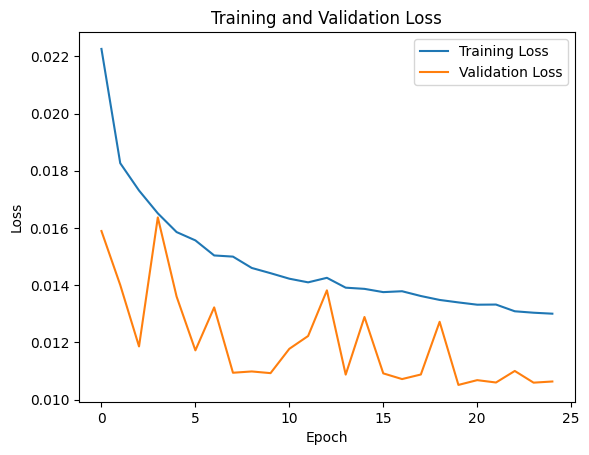

In [ ]:
plt.plot(history_gru.history['loss'], label='Training Loss')
plt.plot(history_gru.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [ ]:
gru_predictions = model_gru.predict(X_test)

calculate_metrics(gru_predictions)

218/218 [==============================] - 1s 3ms/step
Mean Absolute Error: 7.597738293766804
Mean Squared Error: 1118.5522868126532
Root Mean Squared Error: 33.444764714565615


In [ ]:
comparison(y_test, gru_predictions)

,Timestamp,Actual_AQI,Predicted_AQI
0,2023-05-10 14:00:00,28.0,27.627258
1,2023-05-10 15:00:00,28.0,27.994450
2,2023-05-10 16:00:00,28.0,27.172462
3,2023-05-10 17:00:00,28.0,27.167225
4,2023-05-10 18:00:00,28.0,27.261768
...,...,...,...
395,2023-05-27 01:00:00,27.0,27.313038
396,2023-05-27 02:00:00,26.0,27.306519
397,2023-05-27 03:00:00,26.0,28.648285
398,2023-05-27 04:00:00,27.0,28.285400


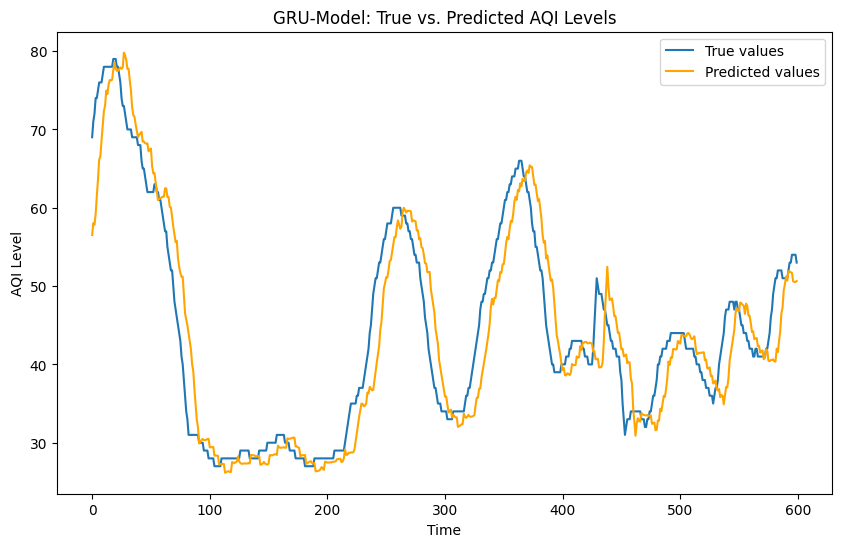

In [ ]:
plot(y_test, gru_predictions, 'GRU')

# LSTM

In [ ]:
model_lstm = keras.Sequential()
model_lstm.add(keras.layers.LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2])))
model_lstm.add(Dense(50, activation='tanh'))
model_lstm.add(Dense(1))
model_lstm.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               70144     
                                                                 
 dense_4 (Dense)             (None, 50)                6450      
                                                                 
 dense_5 (Dense)             (None, 1)                 51        
                                                                 
Total params: 76645 (299.39 KB)
Trainable params: 76645 (299.39 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model_lstm.compile(optimizer='adam', loss='mae')
history_lstm = model_lstm.fit(X_train, y_train, batch_size=64, epochs=50, validation_data=(X_test, y_test), callbacks=[early_stopping])

Epoch 1/50
436/436 [==============================] - 8s 12ms/step - loss: 0.0152 - val_loss: 0.0117
Epoch 2/50
436/436 [==============================] - 4s 9ms/step - loss: 0.0147 - val_loss: 0.0120
Epoch 3/50
436/436 [==============================] - 4s 8ms/step - loss: 0.0146 - val_loss: 0.0109
Epoch 4/50
436/436 [==============================] - 4s 9ms/step - loss: 0.0143 - val_loss: 0.0109
Epoch 5/50
436/436 [==============================] - 5s 11ms/step - loss: 0.0141 - val_loss: 0.0111
Epoch 6/50
436/436 [==============================] - 4s 8ms/step - loss: 0.0139 - val_loss: 0.0116
Epoch 7/50
436/436 [==============================] - 4s 8ms/step - loss: 0.0138 - val_loss: 0.0111
Epoch 8/50
436/436 [==============================] - 6s 13ms/step - loss: 0.0136 - val_loss: 0.0113
Epoch 9/50
436/436 [==============================] - 5s 11ms/step - loss: 0.0136 - val_loss: 0.0133
Epoch 10/50
436/436 [==============================] - 4s 9ms/step - loss: 0.0135 - val_loss: 0.

In [ ]:
# model_lstm.save("/content/drive/MyDrive/air_prediction_diploma/26_4_models/model_lstm_1.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


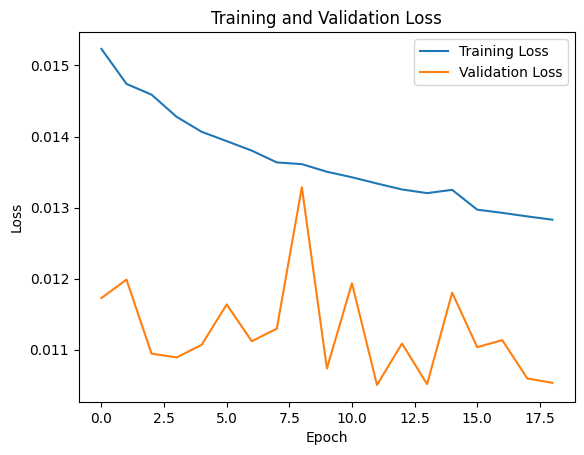

In [ ]:
plt.plot(history_lstm.history['loss'], label='Training Loss')
plt.plot(history_lstm.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [ ]:
predictions_lstm = model_lstm.predict(X_test)

calculate_metrics(predictions_lstm)

218/218 [==============================] - 1s 4ms/step
Mean Absolute Error: 5.177258105667968
Mean Squared Error: 580.958812201879
Root Mean Squared Error: 24.103087192346937


In [ ]:
comparison(y_test, predictions_lstm)

,Timestamp,Actual_AQI,Predicted_AQI
0,2023-05-10 14:00:00,28.0,31.671875
1,2023-05-10 15:00:00,28.0,34.451416
2,2023-05-10 16:00:00,28.0,28.318943
3,2023-05-10 17:00:00,28.0,27.985832
4,2023-05-10 18:00:00,28.0,28.316662
...,...,...,...
395,2023-05-27 01:00:00,27.0,28.727371
396,2023-05-27 02:00:00,26.0,29.645054
397,2023-05-27 03:00:00,26.0,32.281109
398,2023-05-27 04:00:00,27.0,30.437347


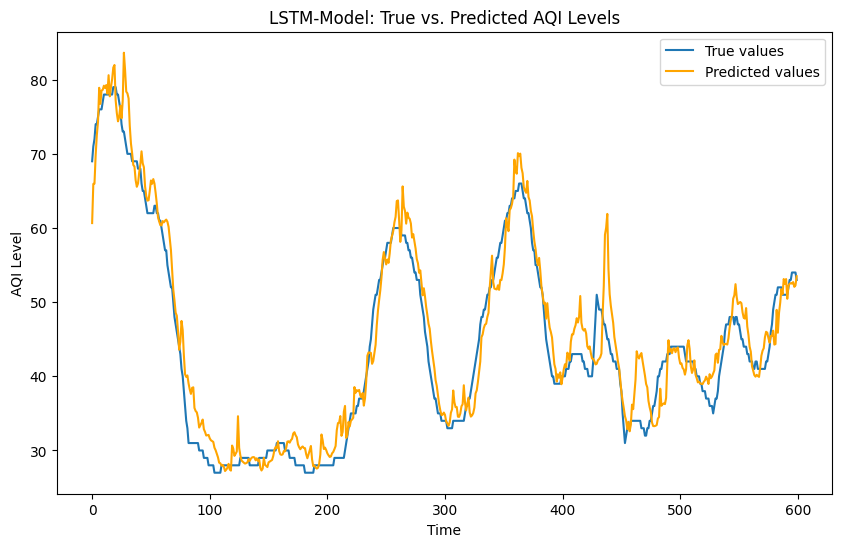

In [ ]:
plot(y_test, predictions_lstm, 'LSTM')

# BiLSTM

In [ ]:
model_BiLSTM = keras.Sequential([
    keras.layers.Bidirectional(keras.layers.LSTM(100,  return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])),
    keras.layers.Dropout(0.4),
    keras.layers.Bidirectional(keras.layers.LSTM(100, return_sequences=False)),
    keras.layers.Dropout(0.4),
    keras.layers.Dense(1)
])
model_BiLSTM.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirection  (None, 120, 200)          87200     
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 120, 200)          0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 200)               240800    
 onal)                                                           
                                                                 
 dropout_1 (Dropout)         (None, 200)               0         
                                                                 
 dense_6 (Dense)             (None, 1)                 201       
                                                                 
Total params: 328201 (1.25 MB)
Trainable params: 32820

In [ ]:
model_BiLSTM.compile(optimizer='adam', loss='mae')
history_bilstm = model_BiLSTM.fit(X_train, y_train, batch_size=64, epochs=50, validation_data=(X_test, y_test), callbacks=[early_stopping])

Epoch 1/50
436/436 [==============================] - 22s 33ms/step - loss: 0.0312 - val_loss: 0.0136
Epoch 2/50
436/436 [==============================] - 13s 30ms/step - loss: 0.0202 - val_loss: 0.0122
Epoch 3/50
436/436 [==============================] - 16s 36ms/step - loss: 0.0184 - val_loss: 0.0117
Epoch 4/50
436/436 [==============================] - 12s 28ms/step - loss: 0.0175 - val_loss: 0.0112
Epoch 5/50
436/436 [==============================] - 12s 29ms/step - loss: 0.0170 - val_loss: 0.0123
Epoch 6/50
436/436 [==============================] - 14s 32ms/step - loss: 0.0166 - val_loss: 0.0135
Epoch 7/50
436/436 [==============================] - 12s 28ms/step - loss: 0.0163 - val_loss: 0.0113
Epoch 8/50
436/436 [==============================] - 11s 25ms/step - loss: 0.0163 - val_loss: 0.0113
Epoch 9/50
436/436 [==============================] - 12s 27ms/step - loss: 0.0161 - val_loss: 0.0111
Epoch 10/50
436/436 [==============================] - 13s 29ms/step - loss: 0.015

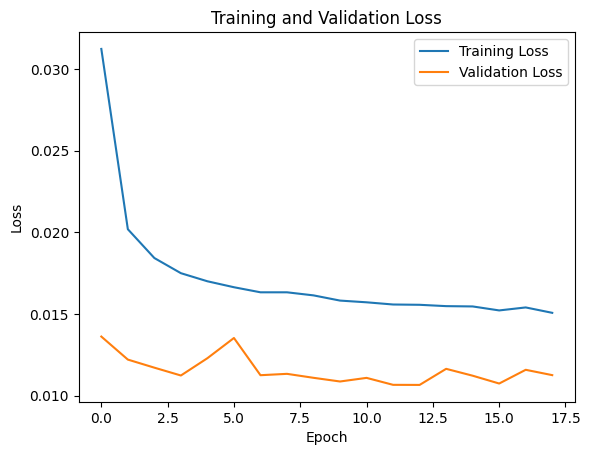

In [ ]:
plt.plot(history_bilstm.history['loss'], label='Training Loss')
plt.plot(history_bilstm.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [ ]:
# model_BiLSTM.save("/content/drive/MyDrive/air_prediction_diploma/26_4_models/model_BiLSTM_12.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
prediction_bilstm_24 = model_BiLSTM.predict(X_test)

calculate_metrics(prediction_bilstm_24)

218/218 [==============================] - 5s 11ms/step
Mean Absolute Error: 5.250952056764359
Mean Squared Error: 591.0952957774923
Root Mean Squared Error: 24.312451455529786


In [ ]:
comparison(y_test, prediction_bilstm_24)

,Timestamp,Actual_AQI,Predicted_AQI
0,2023-05-10 14:00:00,28.0,27.601761
1,2023-05-10 15:00:00,28.0,30.678764
2,2023-05-10 16:00:00,28.0,26.975914
3,2023-05-10 17:00:00,28.0,24.928112
4,2023-05-10 18:00:00,28.0,24.465240
...,...,...,...
395,2023-05-27 01:00:00,27.0,25.144327
396,2023-05-27 02:00:00,26.0,26.166706
397,2023-05-27 03:00:00,26.0,28.620041
398,2023-05-27 04:00:00,27.0,28.127548


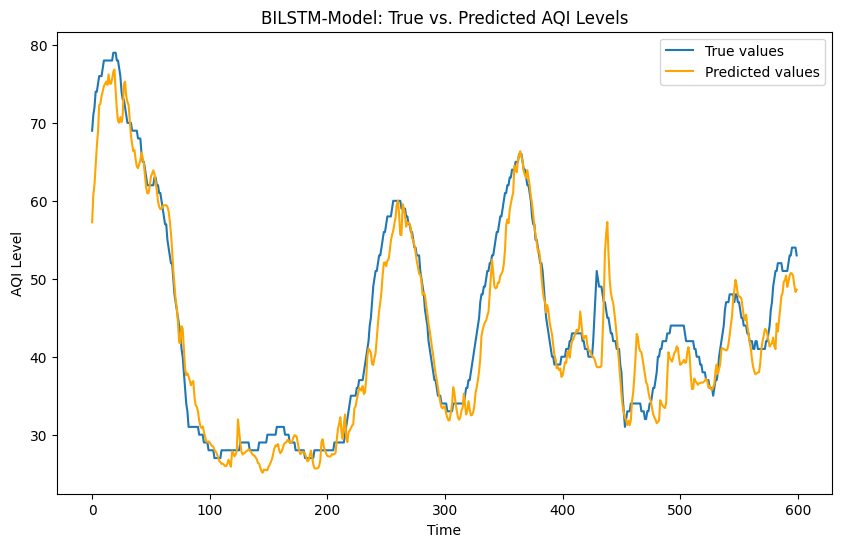

In [ ]:
plot(y_test, prediction_bilstm_24, 'BILSTM')